<style>
.rendered_html * + p, .rendered_html p {
    text-align:justify;
}
.print {
    display:none;
}
.highlight {
    background:white;
}
@media print {
 a[href]:after {
     content: ""
 }
 .noprint {
  display:none
  }
  .print {
        display:block;
    }
}
</style>
<head>
    <base target="_blank">
</head>
<div style="text-align:left"><a href="http://web.dmi.unict.it/"><img src="img/dmi.png" style="width:300px; margin:0;"></a></div>

<a href="http://iplab.dmi.unict.it/"><img src="img/iplab.png" style="width:900px"></a>
<center><h2>Machine Learning - A.A. 2020-2021</h2></center>
<center><h3>Recurrent Neural Networks (RNN) e Long-Short Term Memory Networks (LSTM)</h3></center>
<br>
<center>Antonino Furnari <a href="http://www.antoninofurnari.it/" target="_blank">http://www.antoninofurnari.it/</a> - <a href="mailto:furnari@dmi.unict.it">furnari@dmi.unict.it</a> </center>
<center>Alessandro Ortis <a href="http://www.dmi.unict.it/~ortis/ " target="_blank">http://www.dmi.unict.it/~ortis/ </a> - <a href="mailto:ortis@dmi.unict.it">ortis@dmi.unict.it</a> </center>
<center>Giovanni Maria Farinella <a href="http://www.dmi.unict.it/farinella/" target="_blank">http://www.dmi.unict.it/farinella/</a> - <a href="mailto:gfarinella@dmi.unict.it">gfarinella@dmi.unict.it</a> </center>

In questo laboratorio vedremo come costruire ed allenare un modello di tipo LSTM. I modelli visti finora analizzano ciascun dato in input in maniera totalmente indipendente e pertanto essi sono limitati quando è necessario processare delle sequenze di dati. Si pensi ad esempio a un video: una CNN può essere utilizzata per analizzare ciascun frame del video, tuttavia l'analisi di ciascun frame sarà totalmente indipendente rispetto agli altri frame e pertanto il modello non potrà modellare le interdipendenze temporali tra frame adiacenti (ad esempio due frame adiacenti verosimilmente contengon scene e oggetti simili). Per risolvere questo problema, sono state proposte le reti ricorrenti (Recurrent Neural Networks - RNN). Una rete ricorrente può essere utilizzata per analizzare una sequenza di dati di lunghezza non fissa. Con riferimento al fatto che i diversi elementi della sequenza sono disponibili in istanti temporali diversi, ciascun passo della computazione è generalmente detto "time-step". Per permettere questo tipo di analisi, il modello mantiene un vettore di "memoria" che viene passato da un time-step al successivo.

# 1 Vanilla Recurrent Neural Networks
Il modello più semplice di rete ricorrente (spesso detto "vanilla RNN") viene definito in maniera ricorsiva utilizzando le seguenti equazioni:

\begin{equation}
h_0 = \mathbf{0}\\
h_t = rnn(x_t, h_{t-1}) = tanh(W_{ih} \cdot x_t + b_{ih} + W_{hh} \cdot h_{t-1} + b_{hh})
\end{equation}

dove $h_t$ ha dimensione $d_h$, $\mathbf{0}$ indica un vettore di dimensione $d_h$ formato da zero, $x_t$ ha dimensione $d_x$ e i parametri del modello sono i pesi $W_{ih}$ ("i" sta per input e "h" per hidden), $b_{ih}$, $W_{hh}$, $b_{hh}$. 

<img src="img/qmark.jpg" style="width:150px; margin-right:30px; float:left">
<b>Domanda 1</b>

Che dimensioni hanno le matrici $W_{ih}$, $W_{hh}$ e i vettori $b_{ih}$, $b_{hh}$?

<img src="img/note.png" style="width:150px; margin-right:30px; float:left">
<b>Risposta 1</b>



La computazione espressa dalla formula sopra può essere riassunta dalla seguente figura:

<img src="img/rnn_detail.png" width="60%">

Come possiamo notare l'input della cella RNN è una coppia di valori $h_{t-1}$ (hidden cell) e $x_t$ (input). Possiamo usare una RNN per analizzare una sequenza di input $\{x_t\}_t$ applicando la cella in maniera ricorsiva come segue:

<img src="img/rnn_sequence.png" width="60%">

Da notare che $h_0$ viene inizializzata con degli zeri (caso base della ricorsione). In questo caso l'input è una sequenza di vettori $\{x_t\}_t$, mentre l'output è una sequenza di vettori $\{h_t\}_t$.

## 1.1 RNN per la classificazione di cognome

Vedremo un semplice esempio di utilizzo di un RNN per classificare sequenze. In particolare, riprenderemo l'esempio proposto dai tutorial di PyTorch (https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html) sulla classificazione di cognomi.

Il problema considerato consiste nell'analizzare un cognome (inteso come una sequenza di caratteri) e classificarne la lingua di appartenenza. Ad esempio "Rossi" dovrebbe essere riconosciuto come un cognome italiano, mentre "Smith" come un cognome inglese. Va notato che per risolvere questo problema, è necessario avere un modello che modelli la sequenza dei caratteri in input e non solo i singoli caratteri in maniera indipendente come visto nei modelli finora analizzati.

Iniziamo scaricando i dati disponibili a questo link: https://download.pytorch.org/tutorial/data.zip. Estraiamo quindi il contenuto dell'archivio nella directory di lavoro. Nella cartella `data/names` sono contenuti dei file di testo nel formato `[lingua].txt`. 

Carichiamo tutti i file, trasformiamo i nomi da unicode a ascii e mettiamo nomi e relative etichette in due liste:

In [1]:
import glob
import unicodedata
import string

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in string.ascii_letters
    )


names = []
labels = []
classes = []

language_files = sorted(glob.glob('data/names/*.txt'))
for f in language_files:
    #otteniamo la lingua dal nome del file
    language = f.split('/')[-1].split('.')[0]
    classes.append(language)
    with open(f, 'r') as ff:
        nn = list(map(unicodeToAscii, ff.readlines()))
    names.extend(nn)
    labels.extend([language]*len(nn))

Controlliamo quanti elementi abbiamo:

In [2]:
len(names), len(labels)

(20074, 20074)

Visualizziamo i primi elementi e le loro etichette:

In [3]:
names[:3], labels[:3]

(['Khoury', 'Nahas', 'Daher'], ['Arabic', 'Arabic', 'Arabic'])

Controlliamo infiene il numero di classi:

In [4]:
len(classes)

18

Il nostro modello dovrà analizzare le sequenze di caratteri, pertanto abbiamo bisogno di trasfromare ciascun carattere in un tensore. Dato che abbiamo un numero finito di caratteri, un approccio possibile consiste nel rappresentare ciascun carattere come un one-hot-vector. Ad esempio, il carattere "a" può essere rappresentato mediante il vettore `[1, 0, 0, ...., 0]` se a è il primo primo carattere dell'alfabeto.

Definiamo il nostro alfabeto considerando tutte le lettere ascii e alcuni segni di punteggiatura:

In [5]:
alphabet = string.ascii_letters + " .,;'"
print(len(alphabet), alphabet)

57 abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'


Il nostro alfabeto contiene `57` elementi. Possiamo trovare l'indice di un dato carattere mediante il metodo `find` delle stringhe:

In [6]:
alphabet.find('a')

0

Scriviamo dunque un codice che trasformi ciascun nome in una sequenza di one hot vector:

In [7]:
import torch
def name_to_tensor(name):
    tensor = torch.zeros(len(name), len(alphabet))
    sequence_idx = range(len(name)) #0, 1, 2, 3, ...
    char_id = [alphabet.find(c) for c in name]
    tensor[sequence_idx, char_id] =1   
    return tensor

Proviamo il codice scritto sopra:

In [8]:
ciao_tensor = name_to_tensor('ciao')

Visualizziamo il one hot vector del carattere 'a' (il terzo):

In [9]:
ciao_tensor[2]

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.])

Assegniamo inoltre ad ogni classe un id numerico:

In [10]:
class_to_id = {c:i for i,c in enumerate(classes)}
id_to_class = {x:y for y,x in class_to_id.items()}
class_to_id['Italian'], id_to_class[9]

(9, 'Italian')

A questo punto trasfromiamo la lista di nomi in una lista di tensori e la lista di classi in una lista di id:

In [11]:
names_tensors = [name_to_tensor(x) for x in names]
labels_id = [class_to_id[x] for x in labels]

Mettiamo insieme quanto visto finora per costruire un oggetto di tipo dataset. Suddivideremo inoltre in training e test set in maniera casuale usando un seed:

In [12]:
from torch.utils.data import Dataset
import numpy as np

class NamesDataset(Dataset):
    def __init__(self, path_to_dir='data', training = True, seed=42, test_size=0.7):
        self.alphabet = string.ascii_letters + " .,;'"
        # Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
        def unicodeToAscii(s):
            return ''.join(
                c for c in unicodedata.normalize('NFD', s)
                if unicodedata.category(c) != 'Mn'
                and c in self.alphabet
            )

        names = []
        labels = []
        classes = []

        language_files = sorted(glob.glob(path_to_dir+'/names/*.txt'))
        for f in language_files:
            #otteniamo la lingua dal nome del file
            language = f.split('/')[-1].split('.')[0]
            classes.append(language)
            with open(f, 'r') as ff:
                nn = list(map(unicodeToAscii, ff.readlines()))
            names.extend(nn)
            labels.extend([language]*len(nn))
            
        #effettuiamo lo split random
        np.random.seed(seed)
        idx = np.random.permutation(len(names))
        idx_train = idx[:int(len(idx)*test_size)]
        idx_test = idx[int(len(idx)*test_size):]
        
        if training:
            names = np.array(names)[idx_train]
            labels = np.array(labels)[idx_train]
        else:
            names = np.array(names)[idx_test]
            labels = np.array(labels)[idx_test]
            
        
        self.class_to_id = {c:i for i,c in enumerate(classes)}
        self.id_to_class = {x:y for y,x in self.class_to_id.items()}
        
        self.names_tensors = [self.name_to_tensor(x) for x in names]
        self.labels_id = [self.class_to_id[x] for x in labels]
        
        
    def name_to_tensor(self, name):
        tensor = torch.zeros(len(name), len(self.alphabet))
        sequence_idx = range(len(name)) #0, 1, 2, 3, ...
        char_id = [self.alphabet.find(c) for c in name]
        tensor[sequence_idx, char_id] =1   
        return tensor

    def __len__(self):
        return len(self.names_tensors)

    def __getitem__(self, idx):
        return self.names_tensors[idx], self.labels_id[idx]

Verifichiamo che tutto funzioni correttamente:

In [13]:
training_set = NamesDataset(training=True)
print(len(training_set))
print(training_set[0][0].shape, training_set[0][1])
print(training_set[925][0].shape, training_set[926][1])

14051
torch.Size([5, 57]) 10
torch.Size([8, 57]) 12


L'oggetto dataset ci permette di caricare i nomi come sequenze di un numero variabile di vettori di dimensione $57$. Ogni vettore è associato a una etichetta. Controlliamo che lo stesso valga per il dataset di test:

In [14]:
test_set = NamesDataset(training=False)
print(len(training_set))
print(test_set[0][0].shape, test_set[0][1])
print(test_set[925][0].shape, test_set[926][1])

14051
torch.Size([3, 57]) 11
torch.Size([4, 57]) 14


Costruiamo adesso dei DataLoader. Dato che ogni sequenza del dataset ha una lunghezza diversa, ultizzeremo intanto un batch size uguale a $1$.

In [15]:
from torch.utils.data import DataLoader
train_loader = DataLoader(training_set, shuffle=True, batch_size=1)
test_loader = DataLoader(test_set, shuffle=False, batch_size=1)

<img src="img/qmark.jpg" style="width:150px; margin-right:30px; float:left">
<b>Domanda 2</b>

Perché non è possibile utilizzare un batch size diverso da 1?

<img src="img/note.png" style="width:150px; margin-right:30px; float:left">
<b>Risposta 2</b>



Costruiamo adesso una architettura basata su RNN che ci permetta di classificare ciascuna sequenza. L'input di questo modello sarà un sequenza, mentre l'output è una etichetta. Dato che ci interessa ottenere un solo valore in output, considereremo solamente l'ultimo valore generato dalla RNN $h_t$. Dato che abbiamo $18$ classi, il nostro output dovrebbe contenere $18$ elementi. Per evitare di imporre che la dimensione del layer nascosto sia pari al numero di classi, introduciamo un layer di tipo `Linear` per trasformare l'ultimo hidden layer nell'output desiderato. Ciò permetterà inoltre di mappare il range dell'hidden layer ($[-1,1]$) su un range arbitrario. Il modello seguirà la seguente architettura:

<img src="img/rnn_sum.png" width="60%">

<img src="img/qmark.jpg" style="width:150px; margin-right:30px; float:left">
<b>Domanda 2</b>

Perché il range dell'hidden layer è $[-1,1]$? In quali casi serve avere un range diverso?

<img src="img/note.png" style="width:150px; margin-right:30px; float:left">
<b>Risposta 2</b>



Definiamo l'architettura facendo uso della implementazione delle RNN fornita da PyTorch:

In [16]:
from torch import nn
class NameClassifier(nn.Module):
    def __init__(self, input_size =57, hidden_size=128, output_size=18):
        super(NameClassifier, self).__init__()
        #In PyTorch le RNN supportando due formati di input:
        # batch_size x seq_len x dim
        # seq_len x batch_size x dim
        #noi specifichiamo batch_first=True per utilizzare il primo formato
        self.rnn = nn.RNN(input_size = input_size, hidden_size = hidden_size, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size)
        

    def forward(self, x):
        # il secondo output contiene il valore dell'ultimo hiddel layer
        # il primo output contiene tutti gli altri valori
        # scartiamo il primo output perché non ci interessano tutti gli output
        _, ht = self.rnn(x)
        
        # ht è nel formato 1 x batch_size, dove "1" indica che la rete ha un solo layer
        # chiamiamo squeeze(0) per rimuovere questo "1"
        
        ht = ht.squeeze(0)
        
        #applichiamo il layer Linear:
        y = self.linear(ht)
        return y

Definiamo adesso la procedura di training del modello in maniera analoga a quanto visto nei laboratori precedenti:

In [17]:
from torch.optim import SGD
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import accuracy_score
from os.path import join

class AverageValueMeter():
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.sum = 0
        self.num = 0
    
    def add(self, value, num):
        self.sum += value*num
        self.num += num
        
    def value(self):
        try:
            return self.sum/self.num
        except:
            return None


def trainval_classifier(model, train_loader, test_loader, exp_name='experiment', lr=0.01, epochs=20, momentum=0.99, logdir='logs'):
    criterion = nn.CrossEntropyLoss() 
    optimizer = SGD(model.parameters(), lr, momentum=momentum) 
    #meters
    loss_meter = AverageValueMeter()
    acc_meter = AverageValueMeter()
    #writer
    writer = SummaryWriter(join(logdir, exp_name))
    #device
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    #definiamo un dizionario contenente i loader di training e test
    loader = {
        'train' : train_loader,
        'test' : test_loader
    }
    #inizializziamo il global step
    global_step = 0
    for e in range(epochs):
        #iteriamo tra due modalità: train e test
        for mode in ['train','test']:
            loss_meter.reset(); acc_meter.reset()
            model.train() if mode == 'train' else model.eval()
            with torch.set_grad_enabled(mode=='train'): #abilitiamo i gradienti solo in training
                for i, batch in enumerate(loader[mode]):
                    x=batch[0].to(device) #"portiamoli sul device corretto"
                    y=batch[1].to(device)
                    output = model(x)
                    
                    #aggiorniamo il global_step
                    #conterrà il numero di campioni visti durante il training
                    n = x.shape[0] #numero di elementi nel batch
                    global_step += n
                    l = criterion(output,y)

                    if mode=='train':
                        l.backward()
                        optimizer.step()
                        optimizer.zero_grad()

                    acc = accuracy_score(y.to('cpu'),output.to('cpu').max(1)[1])
                    loss_meter.add(l.item(),n)
                    acc_meter.add(acc,n)

                    #loggiamo i risultati iterazione per iterazione solo durante il training
                    if mode=='train':
                        writer.add_scalar('loss/train', loss_meter.value(), global_step=global_step)
                        writer.add_scalar('accuracy/train', acc_meter.value(), global_step=global_step)
            #una volta finita l'epoca (sia nel caso di training che test, loggiamo le stime finali)
            writer.add_scalar('loss/' + mode, loss_meter.value(), global_step=global_step)
            writer.add_scalar('accuracy/' + mode, acc_meter.value(), global_step=global_step)
            
        #conserviamo i pesi del modello alla fine di un ciclo di training e test
        torch.save(model.state_dict(),'%s-%d.pth'%(exp_name,e+1))
    return model

Instanziamo ed alleniamo il modello:

In [18]:
model = NameClassifier()
trainval_classifier(model, train_loader, test_loader, 'name_classifier_rnn', lr=1e-4, epochs=1)

NameClassifier(
  (rnn): RNN(57, 128, batch_first=True)
  (linear): Linear(in_features=128, out_features=18, bias=True)
)

Notiamo che il training anche di una sola epoca è molto lento. Ciò è dovuto al fatto che stiamo utilizzando batch size pari a 1. Se proviamo a cambiare il batch size, otteniamo un errore. Ciò è dovuto al fatto che ciascuna sequenza ha una lunghezza diversa e quindi non è possibile concatenare i tensori relative alle singole sequenze in un unico tensore. Ad esempio, due sequenze di shape `[8, 57]` e `[3, 57]` non possono essere concatenate in un unico tensore di shape `[?, 57]`. Per ovviare a questo problema, è possibile formare un batch aggiungendo degli zeri al tensore più piccolo in modo che le due dimensioni coincidano. I due tensori possono essere quindi concatenati in un unico tensore di shape `[2, 8, 57]`. Questa operazione è detta "padding" e può essere implementata come segue in PyTorch:

In [24]:
from torch.nn.utils.rnn import pad_sequence

def collate(elements):
    labels = torch.Tensor([e[1] for e in elements]).long()
    sequences = [e[0] for e in elements]
    batch = pad_sequence(sequences, batch_first = True)
    
    return batch, labels

train_loader = DataLoader(training_set, shuffle=True, batch_size=16, collate_fn=collate)
test_loader = DataLoader(test_set, batch_size=16, collate_fn=collate)

In particolare abbiamo ridefinito la funzione `collate_fn` che viene richiamata dal DataLoader quando è necessario raggruppare una serie di elementi in un batch. Proviamo a visualizzare le shape di qualche batch:

In [25]:
for batch in train_loader:
    print(batch[0].shape)
    break
for batch in train_loader:
    print(batch[0].shape)
    break

torch.Size([16, 10, 57])
torch.Size([16, 12, 57])


<img src="img/qmark.jpg" style="width:150px; margin-right:30px; float:left">
<b>Domanda 3</b>

I batch generati dal dataloader hanno in genere dimensioni diverse. Questo è un problema durante il training? Perché?

<img src="img/note.png" style="width:150px; margin-right:30px; float:left">
<b>Risposta 3</b>



<img src="img/qmark.jpg" style="width:150px; margin-right:30px; float:left">
<b>Domanda 4</b>

Il padding delle sequenze cambia il modo in cui viene effettuato il training? In fase di test è necessario effettuare il padding?

<img src="img/note.png" style="width:150px; margin-right:30px; float:left">
<b>Risposta 4</b>



A questo punto siamo pronti per allenare il modello per più epoche:

In [26]:
model = NameClassifier()
trainval_classifier(model, train_loader, test_loader, 'name_classifier_rnn_16', lr=1e-4, epochs=100)

NameClassifier(
  (rnn): RNN(57, 128, batch_first=True)
  (linear): Linear(in_features=128, out_features=18, bias=True)
)

Alla fine del training, dovremmo ottenere un grafico del genere:

<img src='img/names_rnn_plot2.jpg' width=80%>

La rete ha imparato a classificare le sequenze con una discreta accuracy.

# 2 Long-Short Term Memory (LSTM)

Le RNN definite come abbiamo visto nell'esempio precedente tendono a soffrire di problemi di propagazione dei gradienti in fase di training nel caso di lunghe sequenze. Questi problemi sono generalmente risolti dalle architetture di tipo LSTM. Pur non entrando nei dettagli dell'architettura, vedremo in questo laboratori alcuni esempi con questo modello. Iniziamo convertendo il modello appena allenato mediante una LSTM invece che una semplice RNN "vanilla". Prima di iniziare, importiamo le librerie necessarie:

In [27]:
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
from torch import nn
from torch.autograd import Variable
import torch
from sklearn.utils import shuffle
%matplotlib inline

Per la normalizzazione dei dati utilizzeremo il MinMaxScaler di scikit-learn:

In [28]:
from sklearn.preprocessing import MinMaxScaler

## 2.1 Task 1 - Definizione del problema

In questa prima parte dell'esercitazione definiremo una funzione periodica e verificheremo se una LSTM è in grado di imparare la legge matematica che genera i valori della serie.
Il dataset è costituito da una sequenza di valori della funzione sin(x), per un certo range della variabile indipendente x. 
In una prima fase divideremo la sequenza nota in due sotto sequenze, una di train per allenare la rete ed una di test.
Nella seconda fase invece verificheremo la capacità della rete di generare i valori secondo la legge matematica che dovrebbe aver imparato.
In altre parole, nella seconda fase, durante il test gli input saranno costituiti dai valori predetti dal modello ai passi precedente. Gli errori su queste predizioni quindi influenzeranno le predizioni successive.

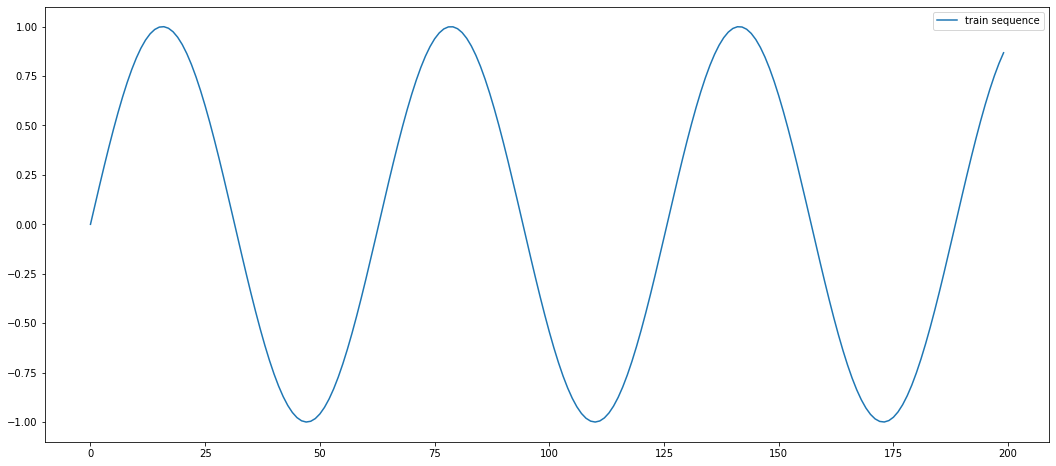

In [29]:
plt.figure(figsize=(18,8))

data = np.sin(np.arange(0.,20.,0.1))
data = data.reshape(len(data),1)
data = data.astype('float32')
plt.plot(data, label = 'train sequence')
plt.legend(loc='best')
plt.show()

L'architettura basata su LSTM che andremo a definire prenderà in input una finestra temporale di valori della serie e dovrà predire il valore successivo.
La dimensione di tale finestra è variabile, in questo modo possiamo verificare come cambiano le prestazioni del modello al variare della dimensione della finestra. 
In questa esercitazione alleneremo il modello utilizzando il 70% delle osservazioni, lasciando il rimanente 30% di dati come test. 

Definiamo inoltre due flag, cioè due valori binari che indicano se scalare i dati e/o mischiare casualmente le sequenze del training set prima del training. Normalmente queste due operazioni vanno sempre fatte, ma mediante l'attivazione o dissattivazione di questi flag possiamo verificare l'effetto sulle prestazioni della mancanza o della presenza di queste operazioni. I dati di train e quelli di test assumono tutti i valori dentro un range prestabilito (come si può notare dalla figura precedente), quindi potrebbe non essere necessario scalare i dati.

In [30]:
window_size = 5     
hidden_size = 10     
NUM_TRIALS = 8000
SCALE = True
SHUFFLE = False      

train_size = int(len(data) * 0.7)
test_size = len(data) - train_size

train = data[0:train_size]
test = data[train_size:len(data)]

Adesso definiremo una funzione per creare un set di dati con cui allenare/testare il modello in maniera opportuna.
Come anticipato, il modello prende in input una finestra temporale di valori della serie e tenta di predire il valore successivo. In questo momento le liste 'train' e 'test' contengono solo due sottosequenze della serie originale.
Occorre quindi definire le coppie di input/output per il nostro modello.

La funzione 'create_dataset' prende due argomenti: il numpy array che contiene la sequenza che vogliamo convertire, ed il numero di osserazioni passate che vogliamo usare come input per il modello per predire il valore temporale successivo. Di default questo paramentro (look_back) è pari a 2, ma possiamo variarlo per ottenere coppie di input/output differenti, ed osservare come variano le prestazioni.

In [31]:
def create_dataset(dataset, look_back=2):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

Definiamo adesso il modello, costituito da una LSTM ed un regressore lineare.

In [32]:
class lstm_regressor(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=1, num_layers=2):
        super(lstm_regressor, self).__init__()
        
        #mettiamo batch_first=True per passare i dati nel formato (batch, seq, feature)
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True) 
        self.regressor = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h, _ = self.rnn(x) #h contiene i valori di tutti gli output
        h=h[:,-1,:] #seleziona l'ultimo output
        h=h.squeeze(1) #trasforma la shape da bs x 1 x hidden_size a bs x hidden_size
        out = self.regressor(h)
        return out

Per normalizzare i dati usiamo il MinMaxScaler con range [0,1]. 
Il dataset quindi viene creato con la funzione 'create_dataset' che crea le coppie (X,y) dove X è una sequenza temporale di dimensione 'window_size', mentre y è il valore della sequenza subito dopo l'ultimo valore in X.


In [33]:
if SCALE:
    train = train.reshape(-1,1)
    scaler = MinMaxScaler(feature_range=(0,1))
    train = scaler.fit_transform(train)
    test = scaler.transform(test)
    train_X, train_Y = create_dataset(train, window_size)
    test_X, test_Y = create_dataset(test, window_size)
else:
    train_X, train_Y = create_dataset(train, window_size)
    test_X, test_Y = create_dataset(test, window_size)


if SHUFFLE:
    train_X, train_Y = shuffle(train_X,train_Y)

train_x = torch.from_numpy(train_X)  
train_y = torch.from_numpy(train_Y)  

il modello prende in input un tensore di shape: (batch size, sequence len, input_size). Verifichiamo le dimensioni dei nostri dati.

In [37]:
print(train_x.shape)
print(train_y.shape)
print(test_X.shape)

torch.Size([135, 5, 1])
torch.Size([135, 1])
(55, 5, 1)


Dopo aver preparato i dati, possiamo definire il modello ed iniziare il training.

Start training
Epoch: 100/8000, Loss: 0.0000328636
Epoch: 200/8000, Loss: 0.0000248828
Epoch: 300/8000, Loss: 0.0000011739
Epoch: 400/8000, Loss: 0.0003954728
Epoch: 500/8000, Loss: 0.0000010713
Epoch: 600/8000, Loss: 0.0000007347
Epoch: 700/8000, Loss: 0.0000005314
Epoch: 800/8000, Loss: 0.0000015196
Epoch: 900/8000, Loss: 0.0000004118
Epoch: 1000/8000, Loss: 0.0000002763
Epoch: 1100/8000, Loss: 0.0002586246
Epoch: 1200/8000, Loss: 0.0000002611
Epoch: 1300/8000, Loss: 0.0000001769
Epoch: 1400/8000, Loss: 0.0025846406
Epoch: 1500/8000, Loss: 0.0000002786
Epoch: 1600/8000, Loss: 0.0000001456
Epoch: 1700/8000, Loss: 0.0021998526
Epoch: 1800/8000, Loss: 0.0000001860
Epoch: 1900/8000, Loss: 0.0000001340
Epoch: 2000/8000, Loss: 0.0000876773
Epoch: 2100/8000, Loss: 0.0000001963
Epoch: 2200/8000, Loss: 0.0000001378
Epoch: 2300/8000, Loss: 0.0000343423
Epoch: 2400/8000, Loss: 0.0000001876
Epoch: 2500/8000, Loss: 0.0000122212
Epoch: 2600/8000, Loss: 0.0000003629
Epoch: 2700/8000, Loss: 0.000000

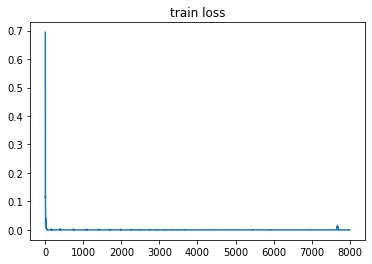

In [40]:
net = lstm_regressor(1, hidden_size) #1 è il numero di feature

 
if torch.cuda.is_available():
    net=net.cuda()
    
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-1)
print("Start training")
train_loss = []
for e in range(NUM_TRIALS):

    var_x = Variable(train_x)
    var_y = Variable(train_y)
    
    out = net(var_x)
    loss = loss_fn(out, var_y)
    train_loss.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (e + 1) % 100 == 0:
        print('Epoch: {}/{}, Loss: {:.10f}'.format(e + 1,NUM_TRIALS, loss.item()))

plt.figure()
plt.plot(train_loss)
plt.title("train loss")
plt.show()


Adesso effettuiamo il test dando in input delle finestre di ampiezza 'window_size' di valori di sen(x).

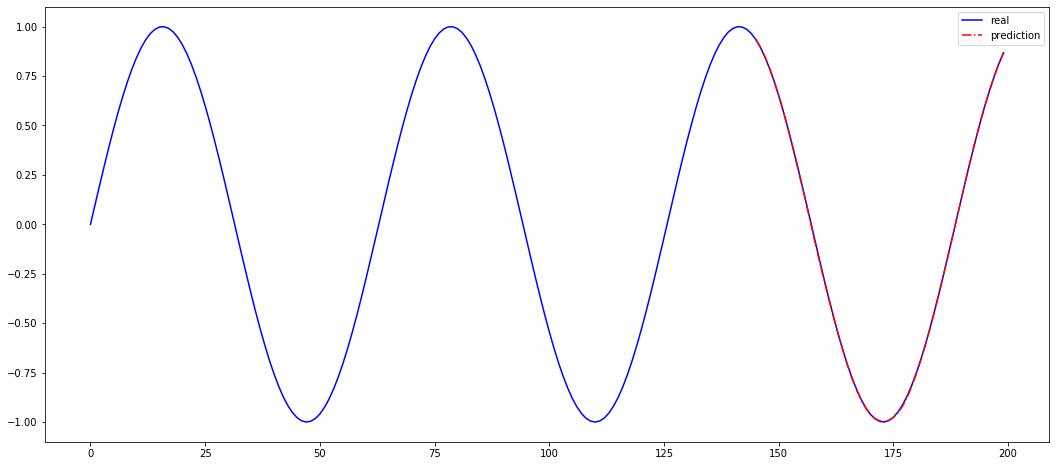

In [41]:
net = net.eval()

data_X = torch.from_numpy(test_X).float()
var_data = Variable(data_X)
pred_test = net(var_data)

pred_test = pred_test.view(-1).data.numpy()
pred_test = scaler.inverse_transform(pred_test.reshape(-1,1))

test_plot = np.empty_like(data)
test_plot[:,:] = np.nan
test_plot[train_size+window_size:len(data), :] = pred_test

plt.figure(figsize=(18,8))
plt.plot(data, 'b', label='real')
plt.plot(test_plot, '-.r', label='prediction')
plt.legend(loc='best')
plt.show()

Come abbiamo appena visto, il modello riesce ad imparare una funzione periodica come la funzione seno.

Adesso proviamo ad effettuare un test più difficile, finalizzato a verificare se il modello riesce a generare dei valori secondo la funzione matematica che ha generato la sequenza di training. Come anticipato, in questo esperimento daremo in input al modello l'ultima finestra del training set, contenente 'window_size' valori 

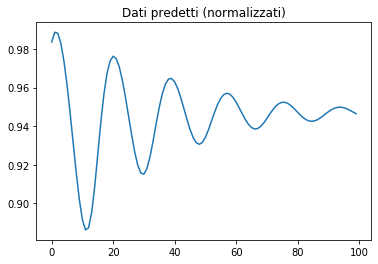

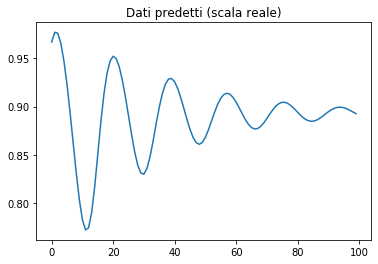

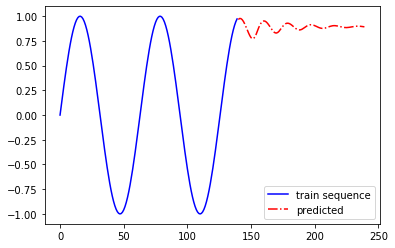

In [42]:
# numero di valori da predire
future_len = 100     
# Test mode
net = net.eval()
# contiene la sequenza generata
prediction = []
# invece di usare valori calcolati con la funzione np.sin(),
# usiamo i valori predetti per definire le finestre di input nel test
test_X = train_X[-1:].copy()
    
while len(prediction)<future_len:
    data_X = torch.from_numpy(test_X).float()
    var_data = Variable(data_X)
    pred_test = net(var_data)
    
    pred_test = pred_test.view(-1).data.numpy().reshape(-1,1)
    prediction = np.append(prediction,pred_test)

    test_X = np.roll(test_X,-1)
    test_X[:,-1,:] = pred_test

plt.figure()
plt.title("Dati predetti (normalizzati)")
plt.plot(prediction)
plt.show()

if SCALE:
    prediction = scaler.inverse_transform(prediction.reshape(-1,1))

plt.figure()
plt.title("Dati predetti (scala reale)")
plt.plot(prediction)
plt.show()

# shift valori di test per visualizzazione
test_plot = np.empty(len(train)+len(prediction))
test_plot[:] = np.nan
test_plot[len(train):len(train)+len(prediction)] = prediction.reshape(-1,len(prediction))

plt.figure()
plt.plot(data[0:train_size], 'b', label='train sequence')
plt.plot(test_plot, '-.r', label='predicted')
plt.legend(loc='best')
plt.show()

## 2.2 Task 2 - Definizione del problema

In questa seconda parte alleneremo una LSTM su una sequenza temporale di dati reali, relativa ai dati mensili del numero di passeggeri internazionali registrati in una particolare area. Tale serie temporale ha una certa periodicità, ed un andamento mediamente crescente nel tempo.

I dati relativi ai passeggeri sono memorizzati in un file 'airport_passengers.csv', scaricabile al seguente link: https://datamarket.com/data/set/22u3/international-airline-passengers-monthly-totals-in-thousands-jan-49-dec-60#!ds=22u3&display=line (o alternativamente http://www.dmi.unict.it/~ortis/downloads/airport_passengers.csv).

Carichiamo i dati sfruttando la libreria Pandas e visualizziamo la sequenza.

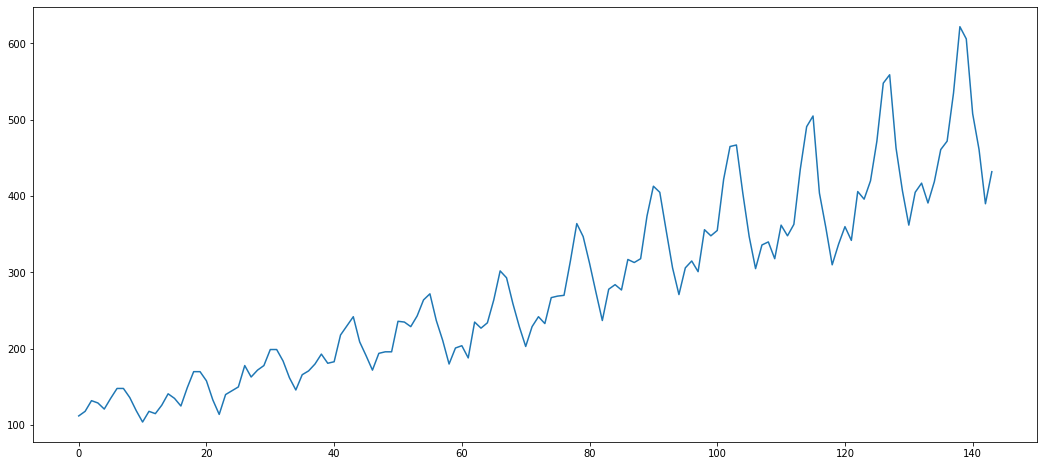

In [43]:
data_csv = pd.read_csv('http://www.dmi.unict.it/ortis/downloads/airport_passengers.csv', usecols=[1])
plt.figure(figsize=(18,8))
plt.plot(data_csv)
plt.show()

data_csv = data_csv.dropna()
dataset = data_csv.values
dataset = dataset.astype('float32')

I dati sono espressi in migliaia, e riportano il numero di passeggeri per ogni mese da Gennaio 1949 a Dicembre 1960, per un totale di 144 osservazioni.
Possiamo osservare una certa periodicità, probabilmente corrispondente al periodo di vacanze nella regione dove sono stati registrati i dati.

Anche in questo caso utilizziamo il primo 70% dei valori della sequenza per il training ed il restante 30% per il test.

In [46]:
# 70% train - 30% test
train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size

train = dataset[0:train_size]
test = dataset[train_size:len(dataset)]
print(dataset.shape)
print(len(train), len(test))
print(train.shape)
print(test.shape)

(144, 1)
100 44
(100, 1)
(44, 1)


Definiamo uno scaler che scala i dati nel range [0,1], la funzione che mappa i dati viene definita utilizzando solo i dati di train. Questa funzione viene quindi applicata sia ai dati di train sia a quelli di test.

In [47]:
scaler = MinMaxScaler(feature_range=(0,1))
train = scaler.fit_transform(train)
test = scaler.transform(test)

Definiamo la lunghezza della finestra temporale di input,la dimensione dell'hidden layer (cioè il numero di blocchi LSTM) tramite una variabile ed il numero di epoche.

In [48]:
window_size = 10
hidden_size = 12
NUM_TRIALS = 7000

Utilizziamo la funzione 'create_dataset' per ottenere le coppie di input/output sia per il train che per il test set.

In [49]:
train_X, train_Y = create_dataset(train, window_size)
test_X, test_Y = create_dataset(test, window_size)

Verifichiamo le dimensioni dei dati, ricordandoci che il modello prende in input un tensore di shape: (batch size, sequence len, input_size).

In [51]:
train_x = torch.from_numpy(train_X)
train_y = torch.from_numpy(train_Y)


print(train_x.shape)
print(train_y.shape)

torch.Size([90, 10, 1])
torch.Size([90, 1])


Istanziamo il modello, definiamo la loss e l'ottimizzatore. 

In [52]:
net = lstm_regressor(1, hidden_size) #1 è il numero di feature

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)


Adesso abbiamo tutto quello che ci serve per fare partire il training.

In [54]:
if torch.cuda.is_available():
    net=net.cuda()
    
for e in range(NUM_TRIALS):

    var_x = Variable(train_x)
    var_y = Variable(train_y)

    out = net(var_x)
    loss = loss_fn(out, var_y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (e + 1) % 100 == 0:
        print('Epoch: {}/{}, Loss: {:.10f}'.format(e + 1,NUM_TRIALS, loss.item()))


Epoch: 100/7000, Loss: 0.0149433017
Epoch: 200/7000, Loss: 0.0140779866
Epoch: 300/7000, Loss: 0.0135959797
Epoch: 400/7000, Loss: 0.0129886009
Epoch: 500/7000, Loss: 0.0121450303
Epoch: 600/7000, Loss: 0.0107330959
Epoch: 700/7000, Loss: 0.0077744764
Epoch: 800/7000, Loss: 0.0057144682
Epoch: 900/7000, Loss: 0.0047629485
Epoch: 1000/7000, Loss: 0.0041850796
Epoch: 1100/7000, Loss: 0.0039307037
Epoch: 1200/7000, Loss: 0.0038001921
Epoch: 1300/7000, Loss: 0.0036460485
Epoch: 1400/7000, Loss: 0.0034370923
Epoch: 1500/7000, Loss: 0.0030851287
Epoch: 1600/7000, Loss: 0.0026182360
Epoch: 1700/7000, Loss: 0.0021465144
Epoch: 1800/7000, Loss: 0.0018903754
Epoch: 1900/7000, Loss: 0.0017202762
Epoch: 2000/7000, Loss: 0.0015747672
Epoch: 2100/7000, Loss: 0.0014599113
Epoch: 2200/7000, Loss: 0.0013683984
Epoch: 2300/7000, Loss: 0.0012664155
Epoch: 2400/7000, Loss: 0.0013033490
Epoch: 2500/7000, Loss: 0.0010667196
Epoch: 2600/7000, Loss: 0.0010152460
Epoch: 2700/7000, Loss: 0.0008869322
Epoch: 280

Dopo aver allenato il modello valutiamo le prestazioni sul test set.

In [55]:
# Test mode
net = net.eval()

data_X = torch.from_numpy(test_X).float()
var_data = Variable(data_X)
pred_test = net(var_data)


pred_test = pred_test.view(-1).data.numpy()
pred_test = scaler.inverse_transform(pred_test.reshape(-1,1))

Per visualizzare i risultati, plottiamo la sequenza completa e quella predetta. Per fare questo dobbiamo shiftare i valori predetti di un numero di passi pari alla dimensione del training set.

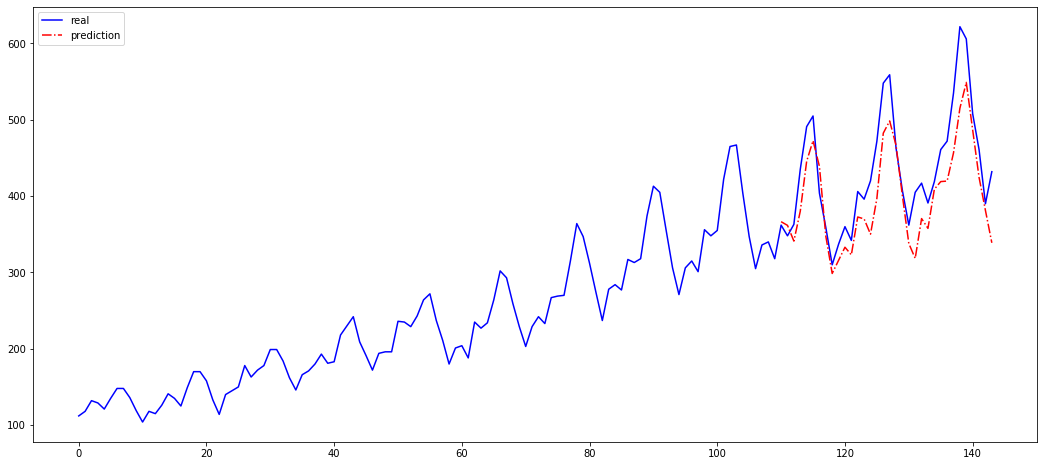

In [56]:
# shift valori di test per visualizzazione
test_plot = np.empty_like(dataset)
test_plot[:,:] = np.nan
test_plot[train_size+window_size:len(dataset), :] = pred_test

plt.figure(figsize=(18,8))
plt.plot(dataset, 'b', label='real')
plt.plot(test_plot, '-.r', label='prediction')
plt.legend(loc='best')
plt.show()

<img src="img/code.png" style="width:150px; margin-right:30px; float:left">
<b>Esercizio 1</b>

Implementare e allenare la rete vista per classificare nomi usando una LSTM.

<img src="img/code.png" style="width:150px; margin-right:30px; float:left">
<b>Esercizio 2</b>

Con riferimento al task 1: definire un range di valori per il parametro window_size, effettuare il training per ciascuno di questi valori e confrontare i risultati ottenuti variando tale parametro.

<img src="img/code.png" style="width:150px; margin-right:30px; float:left">
<b>Esercizio 3</b>

Con riferimento al task 2: definire una funzione che quantifica la bontà della predizione. Ad esempio si può definire una funzione che prende in input la sequenza di test e quella predetta e calcola il valore di Root Mean Squared Error (RMSE).